In [1]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
import geocat.comp
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4
import os
import proplot as pplt
import warnings
from numpy import meshgrid, deg2rad, gradient, cos, sin
from xarray import DataArray
from scipy import stats
from sklearn.preprocessing import StandardScaler as scale
from sklearn import preprocessing
from scipy import signal
warnings.filterwarnings('ignore')

In [2]:
#Specify model names
modelNames=['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CanESM5',
'E3SM-1-1','E3SM-1-1-ECA','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-H','SAM0-UNICON'] #'MIROC-ES2L' file missing, 'MPI-ESM1-2-HR'has bad data??

#othermodels=['MIROC6','MPI-ESM-1-2-HAM','MRI-ESM2-0']

In [3]:
#Preprocessing functions
#3D detrend function
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
    
#1D detrend function
def altdetrend(x:np.ndarray,time:np.ndarray):
        nt = x.shape
        xtemp = x.reshape(nt)
        p = np.polyfit(time, x, deg=1)
        fit = p[0]*(time[:,np.newaxis])+ p[1]
        return x - fit.reshape(nt)
    
def remove_time_mean(x):
        return x - x.mean(dim='time')

def removeSC(x):
        return x.groupby('time.month').apply(remove_time_mean)

# Calculate std normal anomaly
def calStdNorAnom(x):
    a=[]
    for m in np.unique(x.time.dt.month):
        mData=x[x.time.dt.month==m]
        mRolling=mData.rolling(time=31, center=True).mean().bfill(dim="time").ffill(dim="time")
        sRolling=mData.rolling(time=31, center=True).std().bfill(dim="time").ffill(dim="time")
        normData=(mData-mRolling)/sRolling
        a.append(normData)
    combineArray=xr.concat(a,'time')
    outArray=combineArray.sortby('time')
    return outArray

In [10]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
data=xr.open_dataset(files)   
lon=data['lon']
lat=data['lat']
land=data['lsMask']
cres=data['cres']
pr=data['pr']

#Select Monsoon Months
months=[6]
lagmonths=[2]
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
cres=cres.where(cres.time.dt.month.isin(lagmonths), drop=True)

time=cres.time

cres=removeSC(cres)

land=land.sel(lon=slice(60,100),lat=slice(10,30))

#Detrend data sets
cres=cres.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

cres=detrend(cres,time)
cres_july=xr.DataArray(cres,coords=[time,lat,lon],dims=['time','lat','lon'])
cres_july

<xarray.DataArray (time: 43, lat: 181, lon: 240)>
array([[[ 4.81843497e-01,  4.81843497e-01,  4.81843497e-01, ...,
          4.81843497e-01,  4.81843497e-01,  4.81843497e-01],
        [ 2.77573527e-01,  2.81819035e-01,  2.95279856e-01, ...,
          2.86168894e-01,  2.86990893e-01,  2.77736597e-01],
        [ 2.03641334e-01,  1.70664078e-01,  1.48613592e-01, ...,
          2.40475412e-01,  2.31234250e-01,  2.13166558e-01],
        ...,
        [-2.42338070e-27, -2.42338070e-27, -2.42338070e-27, ...,
         -2.42338070e-27, -2.42338070e-27, -2.42338070e-27],
        [-2.42338070e-27, -2.42338070e-27, -2.42338070e-27, ...,
         -2.42338070e-27, -2.42338070e-27, -2.42338070e-27],
        [-2.42338070e-27, -2.42338070e-27, -2.42338070e-27, ...,
         -2.42338070e-27,  1.61558713e-27,  1.61558713e-27]],

       [[ 9.37547884e-02,  9.37547884e-02,  9.37547884e-02, ...,
          9.37547884e-02,  9.37547884e-02,  9.37547884e-02],
        [ 2.19763809e-01,  2.11012009e-01,  1.96959815e-01, ...,
          2.55994084e-01,  2.42635911e-01,  2.35184167e-01],
        [ 3.94608805e-01,  3.89542562e-01,  3.59960987e-01, ...,
          4.52286774e-01,  4.26180723e-01,  4.14000090e-01],
...
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27,  3.23117427e-27,  3.23117427e-27],
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27,  3.23117427e-27,  3.23117427e-27],
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27, -1.61558713e-27, -1.61558713e-27]],

       [[-3.08410839e-01, -3.08410839e-01, -3.08410839e-01, ...,
         -3.08410839e-01, -3.08410839e-01, -3.08410839e-01],
        [-1.66267041e-01, -1.88138138e-01, -1.92738310e-01, ...,
         -1.69893431e-01, -1.70330343e-01, -1.84271539e-01],
        [ 6.77861482e-02,  6.02990714e-02,  5.91073104e-02, ...,
          7.56705121e-02,  7.52568042e-02,  7.26348762e-02],
        ...,
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27,  3.23117427e-27,  3.23117427e-27],
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27,  3.23117427e-27,  3.23117427e-27],
        [ 3.23117427e-27,  3.23117427e-27,  3.23117427e-27, ...,
          3.23117427e-27, -1.61558713e-27, -1.61558713e-27]]])
Coordinates:
  * time     (time) float64 2.867e+08 3.182e+08 ... 1.581e+09 1.612e+09
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [15]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
data=xr.open_dataset(files)   
lon=data['lon']
lat=data['lat']
land=data['lsMask']
cres=data['cres']
pr=data['pr']

#Select Monsoon Months
months=[6]
lagmonths=[2]
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
cres=cres.where(cres.time.dt.month.isin(lagmonths), drop=True)

time=cres.time

land=land.sel(lon=slice(60,100),lat=slice(10,30))

#Remove seasonal cycle
cres=removeSC(cres)

#Normalize
cres_july=calStdNorAnom(cres_july)

#Detrend data sets
cres=cres.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

cres=detrend(cres,time)
cres_july=xr.DataArray(cres,coords=[time,lat,lon],dims=['time','lat','lon'])

#Select only the SAM lat,lon range: 60-100E, 10-30N 
precip=prec.sel(lon=slice(60,100),lat=slice(10,30))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

prec_index=removeSC(prec_index)
#Detrend
time=prec_index.time
prec_index=prec_index.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9
        
prec_index=altdetrend(prec_index,time)
prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])

#Normalize
prec_index=calStdNorAnom(prec_index)

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,cres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,extend='both')
corrs1=axes.contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation
corrs2=axes.contour(corr2.lon,corr2.lat,corr2,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='ERA5 South Asia July Precipitation vs July cres Regression')
cbar.set_label('Regression')
#fig.save('ERA5_SAMonsoon_cres_July-April_Regression')

TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

(43, 181, 240)
(43, 181, 240)


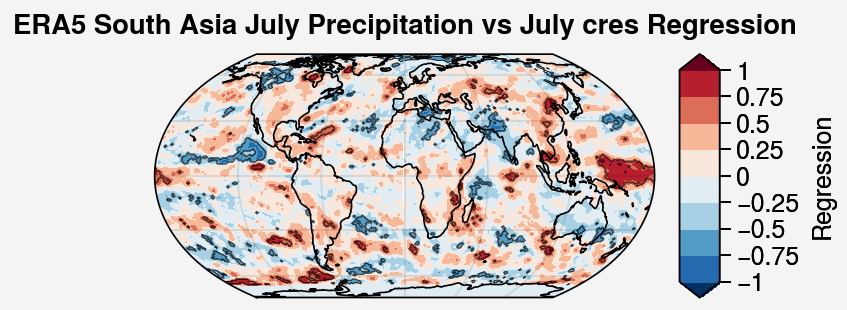

In [17]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
data=xr.open_dataset(files)   
lon=data['lon']
lat=data['lat']
land=data['lsMask']
cres=data['cres']
pr=data['pr']

#Select July Month Indexes
month_idxs=cres.groupby('time.month').groups
july_idxs=month_idxs[7]
april_idxs=month_idxs[6]
cres=cres.isel(time=april_idxs)
prec=pr.isel(time=july_idxs)
time=cres.time
land=land.isel(time=july_idxs)
land=land.sel(lon=slice(60,100),lat=slice(10,30))

#Preprocess cres
t1=cres.stack(z=("lat", "lon"))
# fit scaler on training data
norm = scale().fit(t1)
# transform training data
t1.values = norm.transform(t1)
cres.values=t1.unstack()
cres_july=cres

#Select only the SAM lat,lon range: 60-100E, 10-30N 
precip=prec.sel(lon=slice(60,100),lat=slice(10,30))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

#preprocess precipitation index
prec_index=prec_index.to_numpy()
t3=prec_index
t3=t3.reshape(-1,1)
sc_t=scale()
t3=sc_t.fit_transform(t3)
prec_index=t3.mean(axis=1)

#cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed

print(pr_new.shape)
print(cres_july.shape)
#Calculate variable correlations
corr=xr.corr(pr_new,cres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,extend='both')
corrs1=axes.contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation
corrs2=axes.contour(corr2.lon,corr2.lat,corr2,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='ERA5 South Asia July Precipitation vs July cres Regression')
cbar.set_label('Regression')
#fig.save('ERA5_SAMonsoon_cres_July-April_Regression')

In [ ]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']

#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']
prec=prec*60*60*24 #conversion to mm/day, exluding dividing by density and multiplying by 1000mm/m 

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

#Align times with CMIP time by only looking at 1979-2014
cres=cres[:432,:,:]
precip=prec[:432,:,:]


#Select July index
month_idxs=cres.groupby('time.month').groups
july_idxs=month_idxs[7]
cres_july=cres.isel(time=july_idxs)
prec_july=precip.isel(time=july_idxs)

testtime=cres_july.time

SAMlat=cres_july.lat
SAMlon=cres_july.lon

#Detrend data sets
time=cres_july.time
cres_july=cres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

cres_july=detrend(cres_july,time)
cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

test=preprocessing.Normalizer(prec_july)


In [ ]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']

#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']
prec=prec*60*60*24 #conversion to mm/day, exluding dividing by density and multiplying by 1000mm/m 

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)


#Align times with CMIP time by only looking at 1979-2014
cres=cres[:432,:,:]
precip=prec[:432,:,:]


#Select July index
month_idxs=cres.groupby('time.month').groups
july_idxs=month_idxs[7]
cres_july=cres.isel(time=july_idxs)
prec_july=precip.isel(time=july_idxs)

testtime=cres_july.time

SAMlat=cres_july.lat
SAMlon=cres_july.lon

#Detrend data sets
time=cres_july.time
cres_july=cres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

cres_july=detrend(cres_july,time)
cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

#Select only the SAM lat,lon range: 60-100E, 10-30N 
prec_july=prec_july.sel(lon=slice(60,100))
prec_july=prec_july[:,240:321,:]

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(prec.lat))
prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))

fig,axes = pplt.subplots([[1]])
axes.plot(testtime,prec_index)
axes.format(suptitle='ERA5 South Asia July Precipitation')
axes.format(ylabel='Precipitation (mm/day)')
#fig.save('ERA5_SAMonsoon_July_Precseries')

In [ ]:
#CMIP6 Precipitation Index Script
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    
    cres=cres[1548:,:,:]
    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    prec=prec*60*60*24
    
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=july_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    
    #Do weighted correction on precipitation
    weights=np.cos(np.deg2rad(prec.lat))
    prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))

    con=axes[i].plot(testtime,prec_index)
    axes[i].set_title(name)
axes.format(suptitle='CMIP6 Model South Asia July Precipitation')
#fig.save('SAMonsoon_July_Precseries')

In [ ]:
#CMIP6 models with different time format precipitation index plot
#Do now for other models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4]])
for i,name in enumerate(othermodels):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    cres=data['cres']
    
    cres=cres[1548:,:,:]
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    prec=prec*60*60*24 #conversion to mm/day, exluding dividing by density and multiplying by 1000mm/m 
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   
    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=july_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    
    #Do weighted correction on precipitation
    weights=np.cos(np.deg2rad(prec.lat))
    prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))
    
    con=axes[i].plot(testtime,prec_index)
    axes[i].set_title(name)
#fig.save('OTHER_SAMonsoon_July_Precseries')

In [ ]:
#ERA5 PRECIPITATION INDEX SCRIPT
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']

#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']
prec=prec*60*60*24 #conversion to mm/day, exluding dividing by density and multiplying by 1000mm/m 

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)


#Align times with CMIP time by only looking at 1979-2014
cres=cres[:432,:,:]
precip=prec[:432,:,:]


#Select July index
month_idxs=cres.groupby('time.month').groups
july_idxs=month_idxs[7]
test_idxs=month_idxs[4]
cres_july=cres.isel(time=july_idxs)
prec_july=precip.isel(time=july_idxs)

testtime=cres_july.time

SAMlat=cres_july.lat
SAMlon=cres_july.lon

#Detrend data sets
time=cres_july.time
cres_july=cres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

cres_july=detrend(cres_july,time)
cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

#Select only the SAM lat,lon range: 60-100E, 10-30N 
prec_july=prec_july.sel(lon=slice(60,100))
prec_july=prec_july[:,240:321,:]

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(prec.lat))
prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,cres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,extend='both')
#corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
#corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July ERA5 Two Sigma Above Mean Precipitation vs July cres Regression')
cbar.set_label('Regression')
#fig.save('ERA5_SAMonsoon_cres_July-April_Regression')